Proyecto 1

# IMAGEN_01

In [343]:
import numpy as np
from skimage import io
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, remove_small_holes

## [0] Cargar una de las imágenes histológicas

### Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.

In [344]:
path = 'C:/Users/plane/OneDrive/Escritorio/COMPUTING SCIENCE/MASTER Inteligencia artificial/05_Aprendizaje_supervisado/Entregable/histo_1.jpg'
img = io.imread(path)
rgb = img.copy()


### Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]

In [345]:
rgb_p = rgb.astype('uint8')/255

### Visualizar la imagen

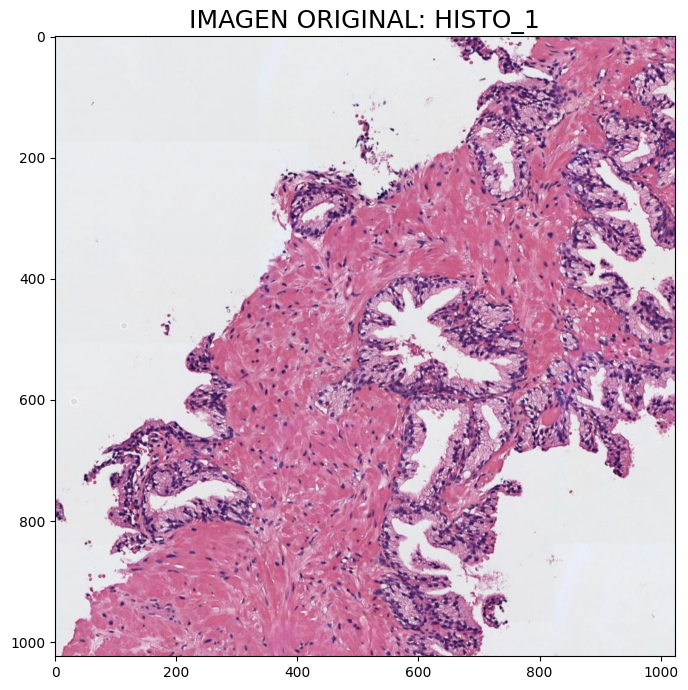

In [346]:
plt.figure(figsize= (8,10))

plt.imshow(img)
plt.title('IMAGEN ORIGINAL: HISTO_1', fontdict= {'fontsize':18})

plt.show()

## [1] Realizar una transformación de color para convertir la imagen al espacio de color CMYK
###  Extraer la componente magenta de la imagen (que corresponde a la región tisular)

In [347]:
def convert_to_CMYK(rgb_p):
    with np.errstate(invalid='ignore', divide='ignore'):
        K = 1 - np.max(rgb_p, axis=2)
        C = (1-rgb_p[:,:,0] - K)/(1-K)
        M = (1-rgb_p[:,:,1] - K)/(1-K)
        Y = (1-rgb_p[:,:,2] - K)/(1-K)
    CMYK = (np.dstack((C,M,Y,K))*255).astype('uint8')
    return CMYK

CMYK_histo_1 = convert_to_CMYK(rgb_p)
C,M,Y,K = cv2.split(CMYK_histo_1)

### Visualizar la imagen del canal magenta

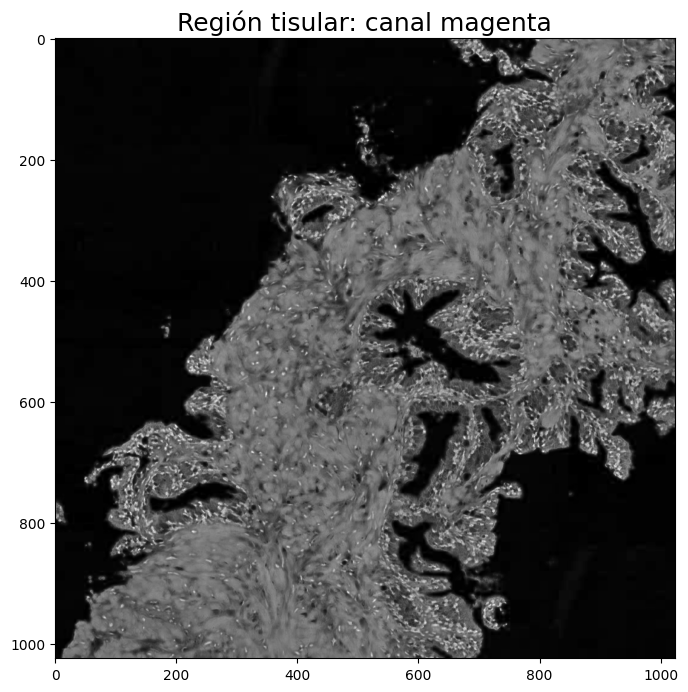

In [348]:
plt.figure(figsize= (8,10))

plt.imshow(M.astype('uint8'), cmap='gray')
plt.title('Región tisular: canal magenta', fontdict= {'fontsize':18})

plt.show()

## [2] Umbralizar la imagen para separar los píxeles del fondo de la región tisular
### Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.

Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".

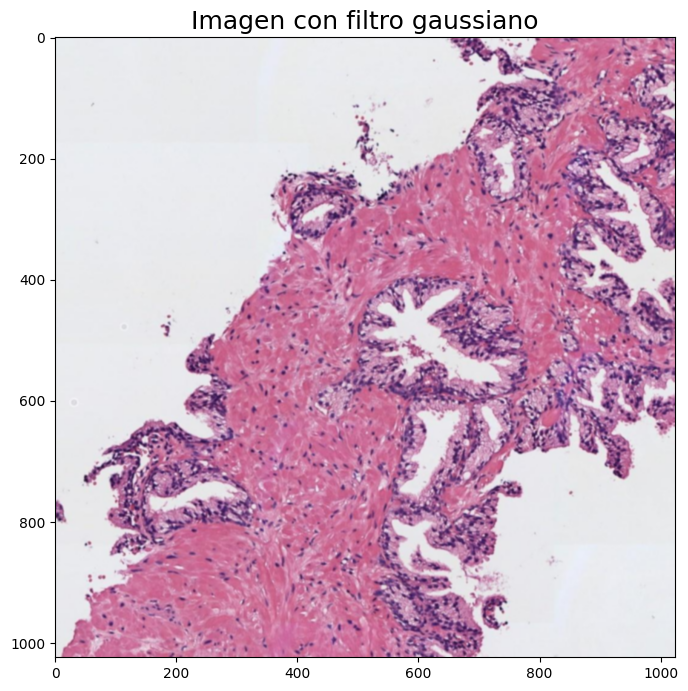

In [349]:
img_gaus = cv2.GaussianBlur(img, (5,5),0) 

plt.figure(figsize= (8,10))
plt.imshow(img_gaus, cmap='gray')
plt.title('Imagen con filtro gaussiano', fontdict= {'fontsize':18})

plt.show()

In [350]:
gray_img = cv2.cvtColor(img_gaus, cv2.COLOR_BGR2GRAY) # al método otsu es necesario pasarle una imagen en gris

t, mask = cv2.threshold(gray_img,0,1,cv2.THRESH_OTSU) # 0 es por defecto y 1 es el valor máximo de la máscara

### Visualizar la máscara resultante

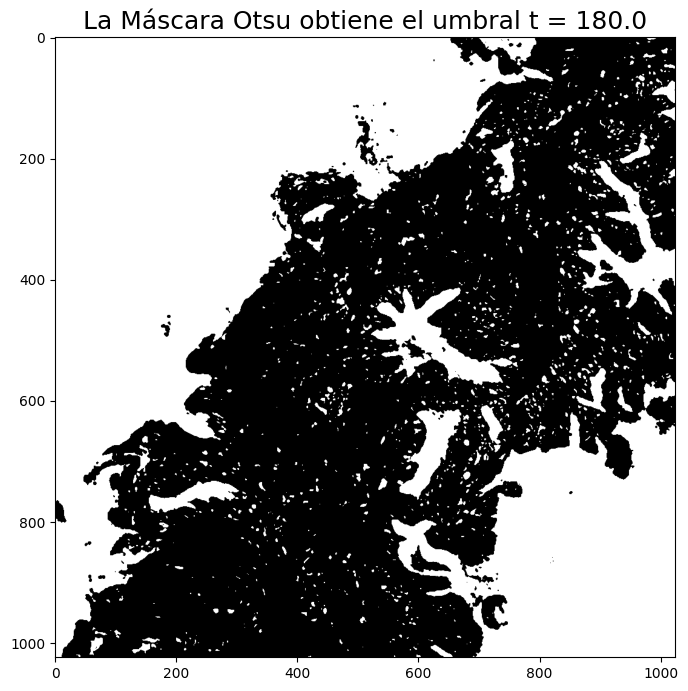

In [351]:
plt.figure(figsize= (8,10))

plt.imshow(mask, cmap='gray')
plt.title(f'La Máscara Otsu obtiene el umbral t = {t}', fontdict= {'fontsize':18})

plt.show()

## [3] Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)
### Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles

Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects

In [352]:
arr = mask > 0
cleaned = remove_small_objects(arr, min_size=300)
img_cleaned = remove_small_holes(cleaned, area_threshold=300)

###  Visualizaer la máscara resultante

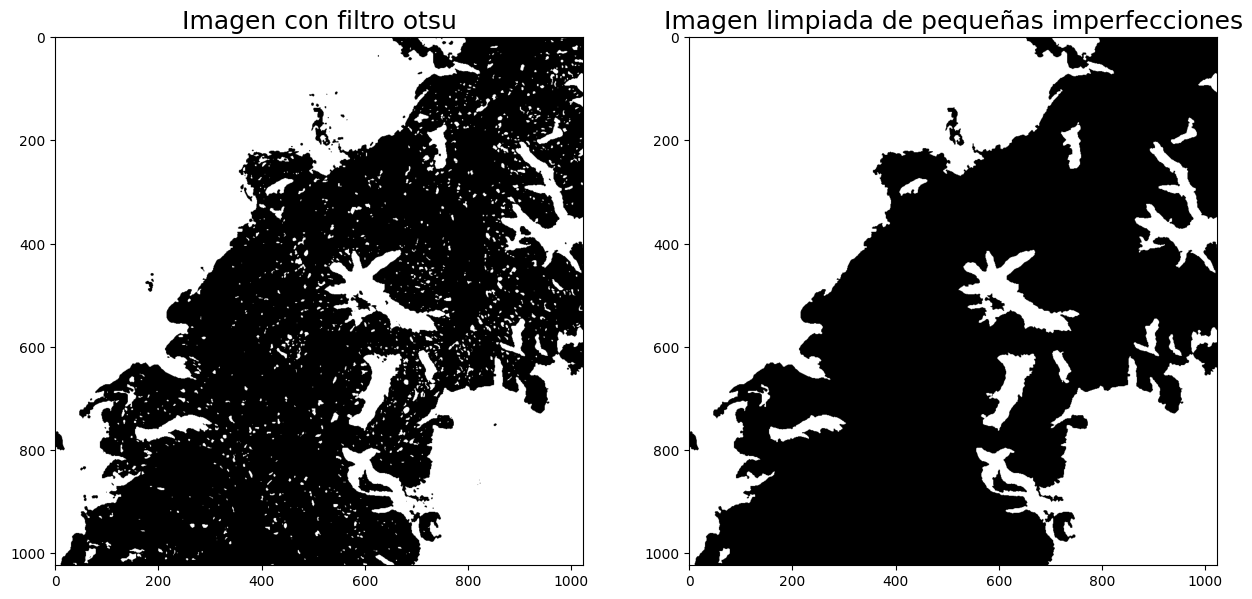

In [353]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15,12)
ax[0].imshow(mask, cmap='gray')
ax[0].set_title('Imagen con filtro otsu', fontdict= {'fontsize':18})
ax[1].imshow(img_cleaned, cmap='gray')
ax[1].set_title('Imagen limpiada de pequeñas imperfecciones', fontdict= {'fontsize':18})

plt.show()

## [4] Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

### Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos y el resto de la imagen negra. 

Pista: utilizar dos semillas.

Nota: Se pueden fijar las semillas de manera manual, pero se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.

In [354]:
mask = img_cleaned.copy().astype(np.uint8)

# Definir una imagen negra de referencia
h, w = img_cleaned.shape
mask_02 = np.zeros((h + 2, w + 2), np.uint8)



cv2.floodFill(mask, mask_02, (0,0), 0)          # semilla 1 esquina superior izquierda
cv2.floodFill(mask, mask_02, (h-1,w-1), 0)      # semilla 2 esquina inferior derecha    

(113323,
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 1],
        [1, 1, 1, ..., 0, 0, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint8),
 (556, 615, 468, 409))

### Visualizar la máscara resultante. 

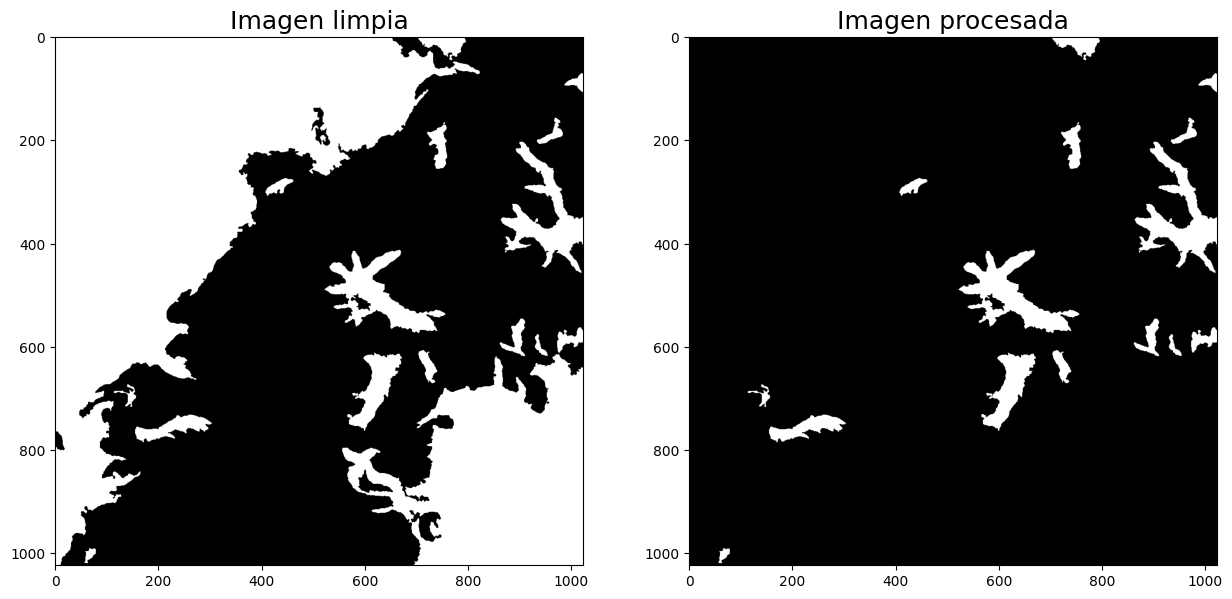

In [355]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,12)

ax[0].imshow(img_cleaned, cmap='gray')
ax[0].set_title('Imagen limpia', fontdict= {'fontsize':18})
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Imagen procesada', fontdict= {'fontsize':18})

plt.show()

## [5] Rellenar los objetos de los lúmenes

### Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology

In [356]:
# Detección de bordes de Canny
# canny = cv2.Canny(mask, 255/3, 255) # minValue and maxValue. Canny recomienda que minValue sea 3 veces mayor que maxValue
# kernel = np.ones((2,2), 'uint8')
# canny = cv2.dilate(canny, kernel, iterations=2) # con esto podemos dilatar los bordes con el tamaño del kernel, en este caso 4
#canny = cv2.erode(canny, kernel, iterations=2) # con esto hacemos lo contrario a dilatar, misma lógica que antes

# plt.imshow(canny, cmap='gray')
# plt.show()

In [357]:
from scipy.ndimage.morphology import binary_fill_holes as bfh
lumenes = mask.copy()
lumenes_rellenos = bfh(lumenes)

C:\Users\plane\AppData\Local\Temp\ipykernel_5480\1089416587.py:1: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_fill_holes as bfh


### Visualizar la máscara resultante

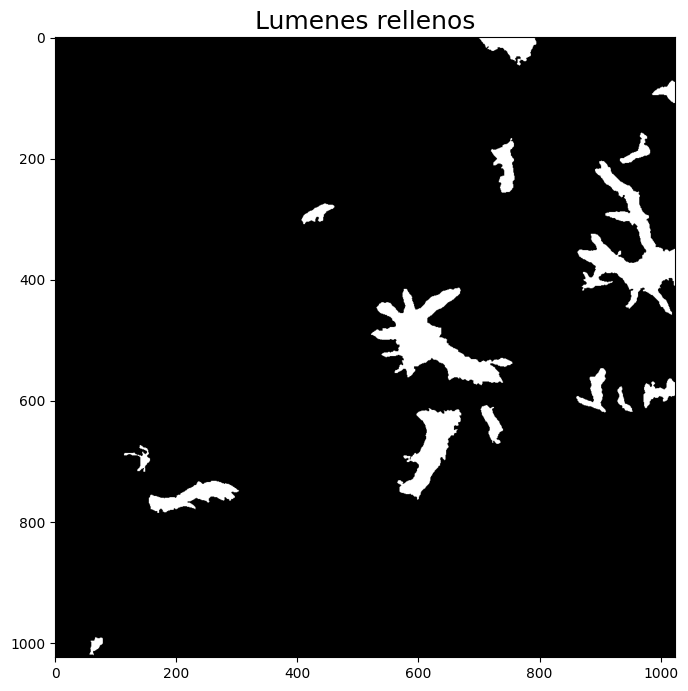

In [358]:
plt.figure(figsize= (8,10))
plt.imshow(lumenes_rellenos.astype('uint8'), cmap='gray')
plt.title('Lumenes rellenos', fontdict= {'fontsize': 18})
plt.show()

## [6] Detectar y dibujar los contornos de los lúmenes sobre la imagen original

### Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. 

Nota: Utilizar los flags necesarios para que los contornos en verde sean perfectamente visibles.

In [359]:
from skimage.morphology import convex_hull_image
from skimage.measure import label
from skimage.measure import regionprops

número de objetos:  15
posibles valores de intensidad:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


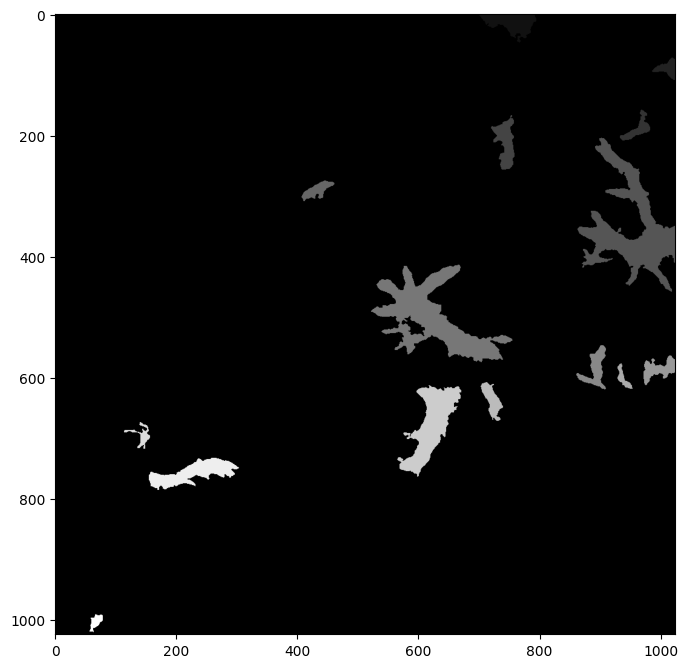

In [360]:
lab, num = label(mask, return_num=True)

print('número de objetos: ', num)
v,c = np.unique(lab, return_counts=True)
print('posibles valores de intensidad: ', v)

plt.figure(figsize= (8,10))
plt.imshow(lab, cmap='gray')
plt.show()

In [361]:
imagen = img.copy()
maskara = mask.copy()

for i in range(1, num+1): 
    objeto = lab == i
    objeto = objeto.astype('uint8')

    # # covex hull
    # convex_image = convex_hull_image(objeto)
    # convex_image = convex_image.astype('uint8')
    # conts,_ = cv2.findContours(convex_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # imagen = cv2.drawContours(imagen, conts, -1, (0,255, 0), 4)

    #img_gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    conts,_ = cv2.findContours(maskara, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    imagen = cv2.drawContours(imagen, conts, -1, (0,255,0), 3)


### Visualizar imagen superpuesta

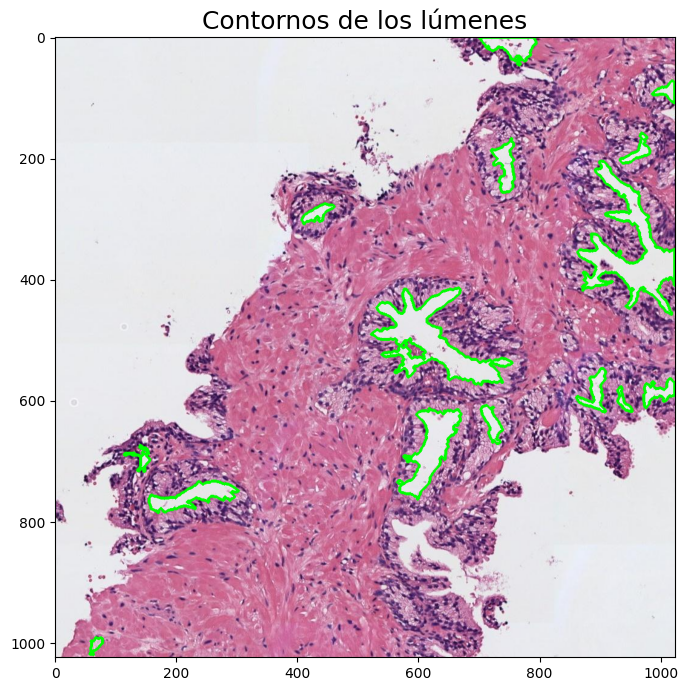

In [362]:
plt.figure(figsize= (8,10))
plt.imshow(imagen, cmap='gray')
plt.title('Contornos de los lúmenes', fontdict= {'fontsize': 18})

plt.show()

## [7] Identificar y cropear el lumen más grande

### Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.

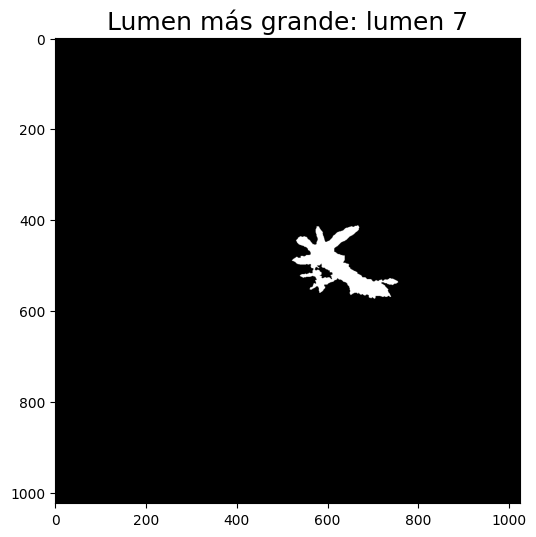

In [363]:
areas = []
for label in v[1:]:    
    objeto = lab == label
    objeto = objeto.astype('uint8')
    prop = regionprops(objeto.astype(np.uint8))
    areas.append(np.round(prop[0].area, 4))
    # print(np.round(prop[0].area, 4))

lumen_mas_grande = max(areas)

for label in v[1:]:
    objeto = lab == label
    objeto = objeto.astype('uint8')
    prop = regionprops(objeto.astype(np.uint8))

    if np.round(prop[0].area, 4) == lumen_mas_grande:

        plt.figure(figsize= (6,8))
        plt.imshow(objeto, cmap='gray')
        plt.title(f'Lumen más grande: lumen {label}', fontdict= {'fontsize': 18})
        plt.show()

### Visualizar el lumen cropeado.

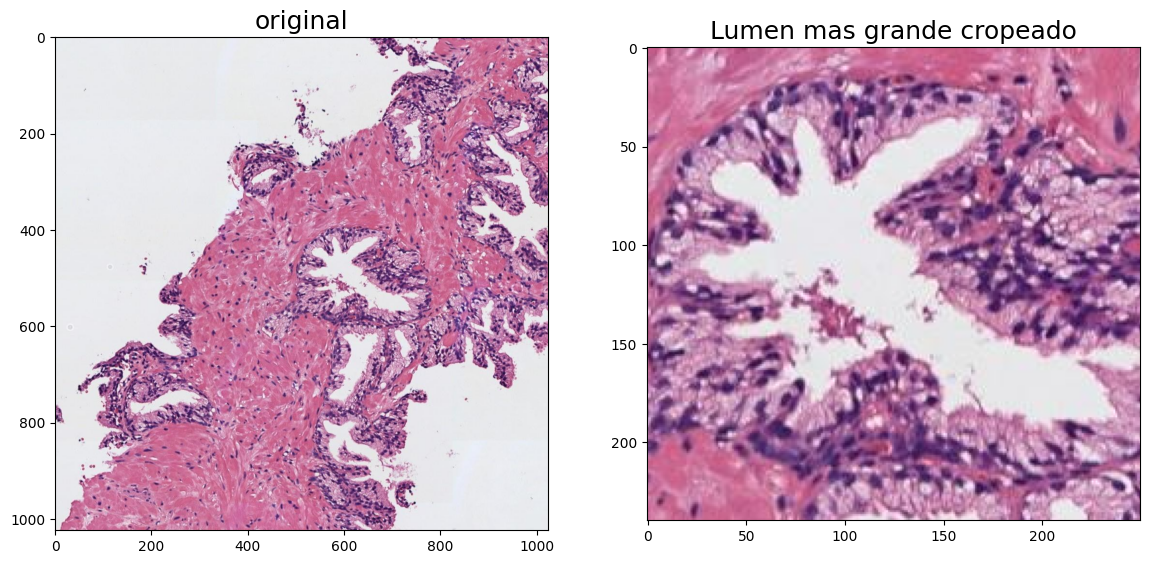

In [364]:
lumen_cropeado = img[380:620, 500:750, :] # si no le especificamos los canales, asume que usaremos todos

fig, ax = plt.subplots(1,2)
fig.set_size_inches(14,8)
ax[0].imshow(img, cmap='gray')
ax[0].set_title('original', fontdict= {'fontsize': 18})

ax[1].imshow(lumen_cropeado, cmap='gray')
ax[1].set_title('Lumen mas grande cropeado', fontdict= {'fontsize': 18})

plt.show()

## [8] Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

### Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.

- Área
- Área de la bounding box
- Área convexa
- Exentricidad
- Diámetro equivalente
- Extensión
- Diámetro Feret
- Longitud del eje mayor
- Longitud del eje menor
- Orientación
- Perímetro
- Solidez
- Compacidad

In [365]:
import pandas as pd 
import math

In [366]:
headers = [ 'Lumen_' + str(label) for label in v[1:]]

A,BB,CA,E,ED,EX,MA,MiA,OR,P,S,CO,R = ['area'], ['bbox_area'], ['convex_area'], ['eccentricity'], ['equiv_diameter'], \
['extent'], ['major_axis'], ['minor_axis'], ['orientation'], ['perimeter'], ['solidity'], ['compactness'], ['rectangularity']

index = list((A,BB,CA,E,ED,EX,MA,MiA,OR,P,S,CO,R))
index = [str(n[0]) for n in index]
print(index)


['area', 'bbox_area', 'convex_area', 'eccentricity', 'equiv_diameter', 'extent', 'major_axis', 'minor_axis', 'orientation', 'perimeter', 'solidity', 'compactness', 'rectangularity']


In [367]:
for label in v[1:]:    
    objeto = lab == label
    prop = regionprops(objeto.astype(np.uint8))
    
    A.append(np.round(prop[0].area, 4))
    BB.append(np.round(prop[0].bbox_area, 4))
    CA.append(np.round(prop[0].convex_area, 4))
    E.append(np.round(prop[0].eccentricity, 4))
    ED.append(np.round(prop[0].equivalent_diameter, 4))
    EX.append(np.round(prop[0].extent, 4))
    MA.append(np.round(prop[0].major_axis_length, 4))
    MiA.append(np.round(prop[0].minor_axis_length, 4))
    OR.append(np.round(prop[0].orientation, 4))
    P.append(np.round(prop[0].perimeter, 4))
    S.append(np.round(prop[0].solidity, 4))
    CO.append(np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4))
    R.append(np.round(prop[0].area/prop[0].bbox_area, 4))


my_data = [tuple(A[1:]), tuple(BB[1:]), tuple(CA[1:]), tuple(E[1:]), tuple(ED[1:]), tuple(EX[1:]), \
          tuple(MA[1:]), tuple(MiA[1:]), tuple(OR[1:]), tuple(P[1:]), tuple(S[1:]), tuple(CO[1:]), tuple(R[1:])]



In [368]:
my_data = (zip(tuple(A[1:]), tuple(BB[1:]), tuple(CA[1:]), tuple(E[1:]), tuple(ED[1:]), tuple(EX[1:]), \
          tuple(MA[1:]), tuple(MiA[1:]), tuple(OR[1:]), tuple(P[1:]), tuple(S[1:]), tuple(CO[1:]), tuple(R[1:])))

my_data_dict = dict(zip(index,(A[1:], BB[1:], CA[1:], tuple(E[1:]), tuple(ED[1:]), tuple(EX[1:]), \
                    tuple(MA[1:]), tuple(MiA[1:]), tuple(OR[1:]), tuple(P[1:]), tuple(S[1:]), tuple(CO[1:]), tuple(R[1:]))))
print(my_data_dict)

{'area': [2339.0, 652.0, 826.0, 1839.0, 12639.0, 842.0, 12833.0, 1385.0, 1256.0, 381.0, 1091.0, 6344.0, 484.0, 3516.0, 351.0], 'bbox_area': [4465.0, 1406.0, 2550.0, 3510.0, 41055.0, 1870.0, 37674.0, 3577.0, 2548.0, 1050.0, 2368.0, 16006.0, 1892.0, 7897.0, 660.0], 'convex_area': [2868.0, 851.0, 1382.0, 2557.0, 28196.0, 1062.0, 27468.0, 2346.0, 1895.0, 570.0, 1436.0, 9547.0, 1226.0, 5257.0, 440.0], 'eccentricity': (0.909, 0.6374, 0.8979, 0.937, 0.7749, 0.9319, 0.8496, 0.8734, 0.8665, 0.952, 0.9437, 0.9435, 0.5891, 0.9784, 0.8757), 'equiv_diameter': (54.572, 28.8124, 32.4299, 48.3889, 126.8561, 32.7424, 127.826, 41.9933, 39.9899, 22.0251, 37.2707, 89.8745, 24.8243, 66.9082, 21.1402), 'extent': (0.5239, 0.4637, 0.3239, 0.5239, 0.3079, 0.4503, 0.3406, 0.3872, 0.4929, 0.3629, 0.4607, 0.3964, 0.2558, 0.4452, 0.5318), 'major_axis': (93.9411, 39.2898, 64.808, 92.9419, 234.8149, 57.4865, 235.9961, 77.9778, 67.2337, 48.7936, 69.3071, 176.7311, 43.2445, 163.2966, 32.1398), 'minor_axis': (39.1477, 

In [369]:
lumenes = pd.DataFrame(data = my_data_dict, index= headers).T
display(lumenes)

Lumen_1    Lumen_2    Lumen_3    Lumen_4     Lumen_5  \
area            2339.0000   652.0000   826.0000  1839.0000  12639.0000   
bbox_area       4465.0000  1406.0000  2550.0000  3510.0000  41055.0000   
convex_area     2868.0000   851.0000  1382.0000  2557.0000  28196.0000   
eccentricity       0.9090     0.6374     0.8979     0.9370      0.7749   
equiv_diameter    54.5720    28.8124    32.4299    48.3889    126.8561   
extent             0.5239     0.4637     0.3239     0.5239      0.3079   
major_axis        93.9411    39.2898    64.8080    92.9419    234.8149   
minor_axis        39.1477    30.2736    28.5255    32.4782    148.4142   
orientation        1.4111    -1.5374    -0.7931     0.0752      0.3020   
perimeter        298.6518   128.9117   180.2670   270.6579   1388.6570   
solidity           0.8156     0.7662     0.5977     0.7192      0.4483   
compactness        0.3295     0.4930     0.3194     0.3155      0.0824   
rectangularity     0.5239     0.4637     0.3239     0.5239      0.3079   

                  Lumen_6     Lumen_7    Lumen_8    Lumen_9   Lumen_10  \
area             842.0000  12833.0000  1385.0000  1256.0000   381.0000   
bbox_area       1870.0000  37674.0000  3577.0000  2548.0000  1050.0000   
convex_area     1062.0000  27468.0000  2346.0000  1895.0000   570.0000   
eccentricity       0.9319      0.8496     0.8734     0.8665     0.9520   
equiv_diameter    32.7424    127.8260    41.9933    39.9899    22.0251   
extent             0.4503      0.3406     0.3872     0.4929     0.3629   
major_axis        57.4865    235.9961    77.9778    67.2337    48.7936   
minor_axis        20.8507    124.4596    37.9703    33.5620    14.9410   
orientation       -1.0882      0.9885    -0.2579    -1.2468     0.4405   
perimeter        162.2670   1316.6865   256.1076   230.8944   116.3259   
solidity           0.7928      0.4672     0.5904     0.6628     0.6684   
compactness        0.4018      0.0930     0.2653     0.2961     0.3538   
rectangularity     0.4503      0.3406     0.3872     0.4929     0.3629   

                 Lumen_11    Lumen_12   Lumen_13   Lumen_14  Lumen_15  
area            1091.0000   6344.0000   484.0000  3516.0000  351.0000  
bbox_area       2368.0000  16006.0000  1892.0000  7897.0000  660.0000  
convex_area     1436.0000   9547.0000  1226.0000  5257.0000  440.0000  
eccentricity       0.9437      0.9435     0.5891     0.9784    0.8757  
equiv_diameter    37.2707     89.8745    24.8243    66.9082   21.1402  
extent             0.4607      0.3964     0.2558     0.4452    0.5318  
major_axis        69.3071    176.7311    43.2445   163.2966   32.1398  
minor_axis        22.9343     58.5670    34.9437    33.7948   15.5205  
orientation        0.3454     -0.4012     0.4106    -1.3529   -0.5895  
perimeter        185.9949    595.1270   195.6457   445.3391   92.5624  
solidity           0.7597      0.6645     0.3948     0.6688    0.7977  
compactness        0.3963      0.2251     0.1589     0.2228    0.5148  
rectangularity     0.4607      0.3964     0.2558     0.4452    0.5318

In [370]:
lumen_de_mayor_area = lumenes['Lumen_7']

lumen_de_mayor_area

area              12833.0000
bbox_area         37674.0000
convex_area       27468.0000
eccentricity          0.8496
equiv_diameter      127.8260
extent                0.3406
major_axis          235.9961
minor_axis          124.4596
orientation           0.9885
perimeter          1316.6865
solidity              0.4672
compactness           0.0930
rectangularity        0.3406
Name: Lumen_7, dtype: float64